In [ ]:
import sys

!{sys.executable} -m pip install transformers[torch] datasets evaluate torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 2.4 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, BertConfig, AutoConfig, set_seed
import numpy as np
import evaluate
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import torch

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

    torch.cuda.empty_cache()

set_seed(42)

Using device: cuda

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# Data loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/dataset

/content/drive/MyDrive/dataset


In [ ]:
df_dev = load_dataset("csv", data_files="subtaskA_clean_dev_cased.csv")
df_test = load_dataset("csv", data_files="subtaskA_clean_test_cased.csv")

# Data partioning

In [ ]:
train_val = df_dev['train'].train_test_split(test_size=0.3, seed=42) # inserire random state
train_val

DatasetDict({
    train: Dataset({
        features: ['comment_text', 'conspiratorial'],
        num_rows: 1288
    })
    test: Dataset({
        features: ['comment_text', 'conspiratorial'],
        num_rows: 552
    })
})

In [ ]:
df_train = train_val["train"]
df_val = train_val["test"]

In [ ]:
df_train = df_train.rename_column("comment_text", "text")
df_train = df_train.rename_column("conspiratorial", "labels")
df_val = df_val.rename_column("comment_text", "text")
df_val = df_val.rename_column("conspiratorial", "labels")
df_test = df_test.rename_column("comment_text", "text")

# Model loading

In [ ]:
nome = 'distilbertITA_default' # modificare
model_name = 'Geotrend/distilbert-base-it-cased'

In [ ]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Data preprocessing

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [ ]:
tokenized_train = df_train.map(tokenize_function, batched=True)
tokenized_val = df_val.map(tokenize_function, batched=True)
tokenized_test = df_test.map(tokenize_function, batched=True)

In [ ]:
tokenized_train

Dataset({
    features: ['text', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 1288
})

In [ ]:
# small_train_dataset = tokenized_train.shuffle(seed=42).select(range(6))
# small_eval_dataset = tokenized_val.shuffle(seed=42).select(range(3))

# Training

In [ ]:
training_args = TrainingArguments(
    output_dir="test_trainer",
    evaluation_strategy = "epoch", # monitor the evaluation metrics during fine-tuning at the end of each epoch
    logging_strategy="epoch",
    num_train_epochs=15,
    #per_device_train_batch_size # default 8
    #per_device_eval_batch_size # default 8
    #learning_rate=0.0005, # default 0.00005
    #weight_decay=0.0001 # default 0 # disastro
    )

In [ ]:
config = AutoConfig.from_pretrained(model_name)

In [ ]:
# config.dropout = 0.001

In [ ]:
print(config)

DistilBertConfig {
  "_name_or_path": "Geotrend/distilbert-base-it-cased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.31.0",
  "vocab_size": 25496
}



In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)

model

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at Geotrend/distilbert-base-it-cased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(25496, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
def compute_metrics(eval_pred):
  # takes as input model predictions, applies argmax to them and comput F-Score between predictions and true labels
  f1_metric = evaluate.load("f1")
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  return f1_metric.compute(predictions=predictions, references=labels, average="macro")

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics
)

In [ ]:
%%time
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.579800,0.550505,0.745723
2,0.453300,0.663395,0.737103
3,0.285800,0.875328,0.774507
4,0.148600,1.201787,0.760555
5,0.060700,1.395976,0.763250
6,0.040000,1.597239,0.749602
7,0.010100,1.719155,0.762337
8,0.001500,1.807264,0.769291
9,0.000300,1.936799,0.773926
10,0.006500,1.996276,0.764490


CPU times: user 16min 26s, sys: 7.58 s, total: 16min 34s
Wall time: 17min 24s


TrainOutput(global_step=2415, training_loss=0.10580720415774648, metrics={'train_runtime': 1043.6867, 'train_samples_per_second': 18.511, 'train_steps_per_second': 2.314, 'total_flos': 2559270142033920.0, 'train_loss': 0.10580720415774648, 'epoch': 15.0})

# Evaluation

In [ ]:
log_history = trainer.state.log_history

In [ ]:
df = pd.DataFrame(columns=["Epoch", "Loss", "Dataset"])

for log_data in log_history:
  epoch = int(log_data["epoch"])
  if "loss" in log_data.keys():
    loss = log_data["loss"]
    df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
  if "eval_loss" in log_data.keys():
    loss = log_data["eval_loss"]
    df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Validation"}, ignore_index=True)
df

<ipython-input-22-ea7900ceb47e>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
<ipython-input-22-ea7900ceb47e>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Validation"}, ignore_index=True)
<ipython-input-22-ea7900ceb47e>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
<ipython-input-22-ea7900ceb47e>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Da

,Epoch,Loss,Dataset
0,1,0.579800,Training
1,1,0.550505,Validation
2,2,0.453300,Training
3,2,0.663395,Validation
4,3,0.285800,Training
5,3,0.875328,Validation
6,4,0.148600,Training
7,4,1.201787,Validation
8,5,0.060700,Training
9,5,1.395976,Validation


In [ ]:
df.to_html(f'loss_{nome}.html')

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Epoch</th>
      <th>Loss</th>
      <th>Dataset</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>1</td>
      <td>0.697200</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>1</th>
      <td>1</td>
      <td>0.669174</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>2</th>
      <td>2</td>
      <td>0.635500</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>3</th>
      <td>2</td>
      <td>0.670862</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>4</th>
      <td>3</td>
      <td>0.587900</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>5</th>
      <td>3</td>
      <td>0.672889</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>6</th>
      <td>4</td>
      <td>0.539400</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>7</th>
      <td>4</td>
      <td>0.677192</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>8</th>
      <td>5</td>
      <td>0.466300</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>9</th>
      <td>5</td>
      <td>0.680526</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>10</th>
      <td>6</td>
      <td>0.411400</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>11</th>
      <td>6</td>
      <td>0.690356</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>12</th>
      <td>7</td>
      <td>0.356700</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>13</th>
      <td>7</td>
      <td>0.708966</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>14</th>
      <td>8</td>
      <td>0.321200</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>15</th>
      <td>8</td>
      <td>0.732528</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>16</th>
      <td>9</td>
      <td>0.293900</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>17</th>
      <td>9</td>
      <td>0.758814</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>18</th>
      <td>10</td>
      <td>0.272400</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>19</th>
      <td>10</td>
      <td>0.784720</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>20</th>
      <td>11</td>
      <td>0.249000</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>21</th>
      <td>11</td>
      <td>0.810367</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>22</th>
      <td>12</td>
      <td>0.233400</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>23</th>
      <td>12</td>
      <td>0.833654</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>24</th>
      <td>13</td>
      <td>0.192100</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>25</th>
      <td>13</td>
      <td>0.852435</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>26</th>
      <td>14</td>
      <td>0.191500</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>27</th>
      <td>14</td>
      <td>0.865037</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>28</th>
      <td>15</td>
      <td>0.180900</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>29</th>
      <td>15</td>
      <td>0.871067</td>
      <td>Validation</td>
    </tr>
  </tbody>
</table>

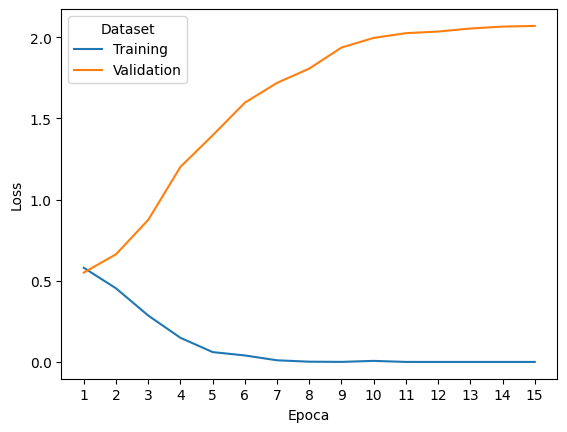

In [ ]:
# loss lineplot
sns.lineplot(data=df, x="Epoch", y="Loss", hue="Dataset")
plt.xticks(range(1, 16))
plt.xlabel('Epoca')
plt.savefig(f'loss_curves_{nome}.pdf', dpi=300, bbox_inches='tight')
plt.show()